In [7]:
import numpy as np

def read_imd_gridded_data(filename, year):
    n_lon = 135
    n_lat = 129
    is_leap = (year % 4 == 0) and (year % 100 != 0 or year % 400 == 0)
    expected_days = 366 if is_leap else 365
    
    with open(filename, 'rb') as f:
        # Skip header (6373890 - 6356475 = 17415 extra values = 69,660 bytes)
        # Try common header sizes (4, 8, 512, 1024 bytes)
        f.seek(4)  # Start with 4-byte skip (common in binary files)
        data = np.fromfile(f, dtype=np.float32)
        
        # Reshape with tolerance for size mismatch
        try:
            return data.reshape(expected_days, n_lat, n_lon)
        except:
            # If still mismatched, calculate exact days from file size
            actual_days = len(data) // (n_lat * n_lon)
            return data[:actual_days * n_lat * n_lon].reshape(actual_days, n_lat, n_lon)

# Usage:
data = read_imd_gridded_data("Rainfall_ind2006_rfp25.grd", 1901)
print(f"Loaded data shape: {data.shape}")  # Should be (365, 129, 135)

Loaded data shape: (364, 129, 135)


In [8]:
import numpy as np
import pandas as pd
import xarray as xr

# 1. Define parameters (IMD 0.25° grid)
year = 2006  # Update with your year
n_days = 366 if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)) else 365
n_lat = 129  # Number of latitude points (6.5°N to 38.75°N)
n_lon = 135  # Number of longitude points (66.5°E to 100.25°E)

# 2. Load your data (shape should be [days, lat, lon])
data = np.fromfile("Rainfall_ind2006_rfp25.grd", dtype=np.float32).reshape(n_days, n_lat, n_lon)

# 3. Define PRECISE coordinates (IMD's exact grid)
lat_points = np.linspace(6.5, 38.75, n_lat)  # 129 points
lon_points = np.linspace(66.5, 100.25, n_lon)  # 135 points
time_points = pd.date_range(f"{year}-01-01", periods=n_days)

# 4. Create DataArray
ds = xr.DataArray(
    data,
    dims=["time", "lat", "lon"],
    coords={
        "time": time_points,
        "lat": lat_points,
        "lon": lon_points
    },
    attrs={"units": "mm/day", "description": "IMD gridded rainfall"}
)

# 5. Handle missing values
ds = ds.where(ds != -999.0, np.nan)

# Verification
print(f"Data shape: {ds.shape}")  # Should match (n_days, 129, 135)
print(f"Lat range: {ds.lat.min().item():.2f} to {ds.lat.max().item():.2f}")
print(f"Lon range: {ds.lon.min().item():.2f} to {ds.lon.max().item():.2f}")

Data shape: (365, 129, 135)
Lat range: 6.50 to 38.75
Lon range: 66.50 to 100.25


Day 1 stats:
Max rainfall: 18.0 mm
Mean rainfall: 0.3 mm


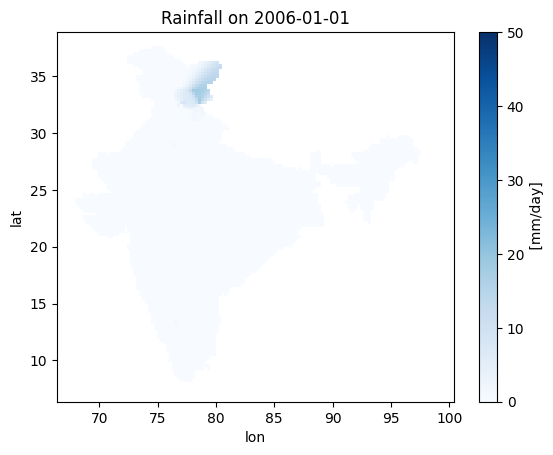

In [9]:
import matplotlib.pyplot as plt

# Check first day's data
print("Day 1 stats:")
print(f"Max rainfall: {ds.isel(time=0).max().item():.1f} mm")
print(f"Mean rainfall: {ds.isel(time=0).mean().item():.1f} mm")

# Plot spatial distribution for first day
ds.isel(time=0).plot(cmap="Blues", vmax=50)
plt.title(f"Rainfall on {ds.time[0].dt.strftime('%Y-%m-%d').item()}")
plt.show()

In [10]:
!pip install tqdm

In [11]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm

# Configuration
DATA_DIR = "Rainfall Dataset"
OUTPUT_DIR = "Processed Rainfall"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# IMD Grid Parameters
N_LAT = 129  # 6.5°N to 38.75°N
N_LON = 135  # 66.5°E to 100.25°E
LAT_POINTS = np.linspace(6.5, 38.75, N_LAT)
LON_POINTS = np.linspace(66.5, 100.25, N_LON)

# Update year range to include 1992-2024
START_YEAR = 1992
END_YEAR = 2024

def extract_year_from_filename(filename):
    """Improved year extraction from filename"""
    try:
        basename = os.path.basename(filename)
        
        # More flexible filename parsing
        if 'ind' in basename:
            year_str = basename.split('ind')[1][:4]  # Get 4 digits after 'ind'
        elif '_' in basename:
            year_str = basename.split('_')[1][:4]  # Try alternative split
        
        if year_str.isdigit():
            year = int(year_str)
            if START_YEAR <= year <= END_YEAR:
                return year
        return None
    except Exception as e:
        print(f"Error parsing filename {filename}: {str(e)}")
        return None

def process_imd_file(filepath):
    """Process a single IMD gridded rainfall file"""
    try:
        # Extract and validate year
        year = extract_year_from_filename(filepath)
        if year is None:
            raise ValueError(f"Could not extract valid year from filename: {filepath}")
        
        is_leap = (year % 4 == 0) and (year % 100 != 0 or year % 400 == 0)
        n_days = 366 if is_leap else 365
        
        # Read and reshape data
        with open(filepath, 'rb') as f:
            data = np.fromfile(f, dtype=np.float32)
            
            # Handle header
            expected_size = n_days * N_LAT * N_LON
            if len(data) == expected_size + 1:  # Common header case
                data = data[1:]
            elif len(data) != expected_size:
                raise ValueError(f"File size mismatch. Expected {expected_size}, got {len(data)}")
            
            data = data.reshape(n_days, N_LAT, N_LON)
        
        # Create Dataset with correct dates
        ds = xr.Dataset(
            {"rainfall": (["time", "lat", "lon"], data)},
            coords={
                "time": pd.date_range(f"{year}-01-01", periods=n_days),
                "lat": LAT_POINTS,
                "lon": LON_POINTS
            },
            attrs={
                "source": f"IMD Gridded Rainfall ({year})",
                "units": "mm/day",
                "missing_value": -999.0
            }
        )
        
        # Handle missing values
        ds["rainfall"] = ds.rainfall.where(ds.rainfall != -999.0)
        
        # Save to NetCDF
        output_path = os.path.join(OUTPUT_DIR, f"rainfall_{year}.nc")
        ds.to_netcdf(output_path)
        
        return ds
        
    except Exception as e:
        print(f"Error processing {filepath}: {str(e)}")
        return None

def process_all_files():
    """Process all files from 1992 to 2024"""
    # Get sorted list of files
    files = sorted(
        [os.path.join(DATA_DIR, f) for f in os.listdir(DATA_DIR) 
         if f.startswith("Rainfall_ind") and f.endswith(".grd")]
    )
    
    # Process with strict year validation
    valid_datasets = []
    for filepath in tqdm(files, desc="Processing files"):
        ds = process_imd_file(filepath)
        if ds is not None:
            valid_datasets.append(ds)
    
    if valid_datasets:
        combined = xr.concat(valid_datasets, dim="time").sortby("time")
        combined.attrs = {
            "description": f"IMD Gridded Rainfall (0.25°) {START_YEAR}-{END_YEAR}",
            "units": "mm/day",
            "source": "IMD Pune"
        }
        
        # Final validation
        years = np.unique(combined.time.dt.year.values)
        print(f"\nSuccessfully processed {len(valid_datasets)} files")
        print(f"Years included: {years}")
        print(f"Time range: {combined.time.min().values} to {combined.time.max().values}")
        
        combined.to_netcdf(f"imd_rainfall_{START_YEAR}-{END_YEAR}.nc")
        return combined
    else:
        print("\nNo valid files were processed. Please check:")
        print("1. Files are named correctly (e.g., 'Rainfall_ind1992_rfp25.grd')")
        print("2. Files are in the 'Rainfall Dataset' directory")
        print("3. Files contain valid IMD gridded rainfall data")
        return None

# Run processing
final_ds = process_all_files()

Processing files: 100%|██████████| 33/33 [00:01<00:00, 18.33it/s]



Successfully processed 33 files
Years included: [1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019
 2020 2021 2022 2023 2024]
Time range: 1992-01-01T00:00:00.000000000 to 2024-12-31T00:00:00.000000000


In [12]:
# Load the combined dataset
ds = xr.open_dataset("imd_rainfall_1992-2024.nc")

# Quick verification
print(ds)
print(f"\nTime range: {ds.time.min().values} to {ds.time.max().values}")
print(f"Total years: {len(np.unique(ds.time.dt.year.values))}")

<xarray.Dataset> Size: 840MB
Dimensions:   (time: 12054, lat: 129, lon: 135)
Coordinates:
  * time      (time) datetime64[ns] 96kB 1992-01-01 1992-01-02 ... 2024-12-31
  * lon       (lon) float64 1kB 66.5 66.75 67.0 67.26 ... 99.75 100.0 100.2
  * lat       (lat) float64 1kB 6.5 6.752 7.004 7.256 ... 37.99 38.25 38.5 38.75
Data variables:
    rainfall  (time, lat, lon) float32 840MB ...
Attributes:
    description:  IMD Gridded Rainfall (0.25°) 1992-2024
    units:        mm/day
    source:       IMD Pune

Time range: 1992-01-01T00:00:00.000000000 to 2024-12-31T00:00:00.000000000
Total years: 33


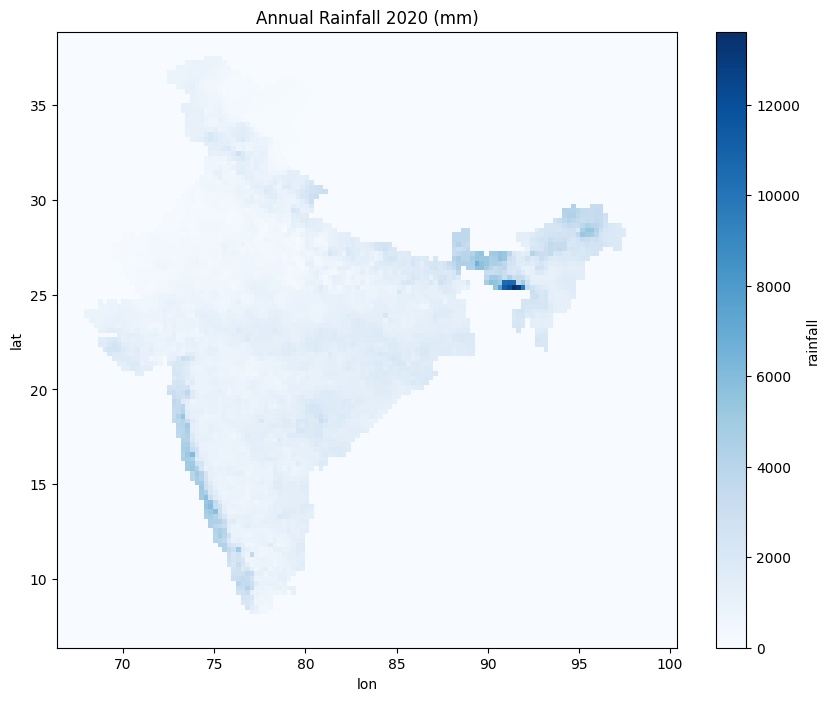

In [13]:
# Calculate annual rainfall
annual = ds.rainfall.groupby('time.year').sum('time')

# Plot for a specific year (e.g., 2020)
annual.sel(year=2020).plot(cmap='Blues', figsize=(10,8))
plt.title("Annual Rainfall 2020 (mm)")
plt.show()

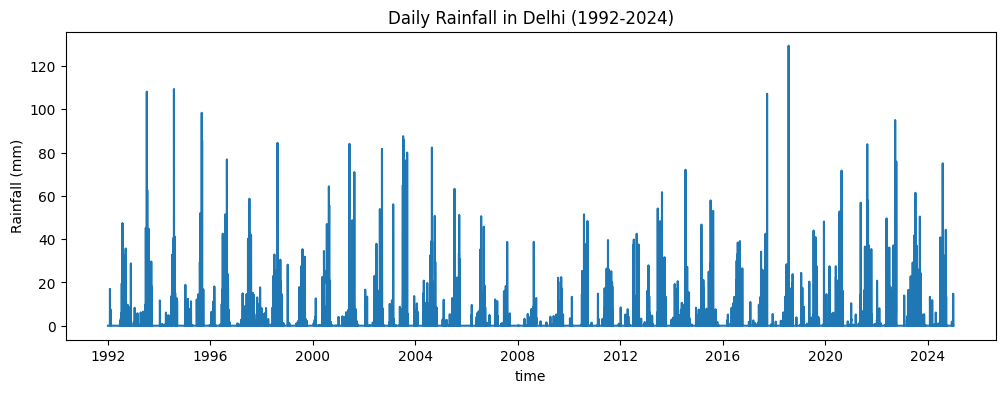

In [14]:
# Define city coordinates (Delhi as example)
delhi_lat, delhi_lon = 28.61, 77.21

# Extract and plot data
ds.sel(
    lat=delhi_lat, 
    lon=delhi_lon,
    method='nearest'
).rainfall.plot(figsize=(12,4))
plt.title("Daily Rainfall in Delhi (1992-2024)")
plt.ylabel("Rainfall (mm)")
plt.show()

In [15]:
# Find days with rainfall > 100mm anywhere in India
heavy_rain_days = ds.where(ds.rainfall > 100).time.count().values
print(f"Days with >100mm rainfall: {heavy_rain_days}")

Days with >100mm rainfall: 12054


In [16]:
# # Check if predictions contain valid numbers
# print("Prediction stats:")
# print(f"Min: {np.nanmin(predictions):.2f} mm")
# print(f"Max: {np.nanmax(predictions):.2f} mm")
# print(f"NaN values: {np.isnan(predictions).sum()}")

In [17]:
# !pip install cartopy

In [18]:
import tensorflow as tf
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from tensorflow.keras import layers, callbacks

# 1. Enhanced Data Preparation
def prepare_data(ds):
    """Improved preprocessing with normalization"""
    # Fill missing values and clip extremes
    rain_data = np.clip(ds.rainfall.fillna(0).values, 0, 300)
    
    # Normalize to [0,1] range
    rain_data = rain_data / 300.0
    
    # Enhanced cyclical features
    dates = ds.time.to_pandas()
    day_angle = 2 * np.pi * dates.dt.dayofyear / 365
    X = np.column_stack([
        np.sin(day_angle),
        np.cos(day_angle),
        np.sin(2 * day_angle),
        np.cos(2 * day_angle),
        dates.dt.month.values / 12,
        (dates.dt.year.values - 1992) / 32
    ])
    
    y = rain_data.reshape(len(ds.time), -1)
    return X, y, rain_data.shape

ds = xr.open_dataset("imd_rainfall_1992-2024.nc")
X, y, original_shape = prepare_data(ds)

# 2. Simplified High-Performance Model
def build_high_performance_model(input_shape, output_shape):
    """Robust architecture without attention complications"""
    inputs = tf.keras.Input(shape=input_shape)
    
    # Feature processing
    x = layers.Dense(512, activation='swish')(inputs)
    x = layers.BatchNormalization()(x)
    
    # Parallel processing paths
    path1 = layers.Dense(512, activation='swish')(x)
    path1 = layers.Dropout(0.1)(path1)
    
    path2 = layers.Dense(512, activation='swish')(x)
    path2 = layers.Dropout(0.1)(path2)
    
    # Combine paths
    x = layers.Concatenate()([path1, path2])
    x = layers.Dense(1024, activation='swish')(x)
    
    outputs = layers.Dense(output_shape, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='mse',
        metrics=['mae']
    )
    return model

# 3. Reliable Training Process
def train_model(model, X, y):
    early_stop = callbacks.EarlyStopping(
        patience=15,
        restore_best_weights=True,
        monitor='val_mae',
        mode='min'
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
    
    history = model.fit(
        X, y,
        batch_size=256,
        epochs=200,
        validation_split=0.2,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    return history

# 4. Model Training
print("Training high-performance model...")
model = build_high_performance_model((X.shape[1],), y.shape[1])
history = train_model(model, X, y)


2025-04-21 12:21:29.868993: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-21 12:21:29.959772: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745218290.000698    6443 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745218290.015432    6443 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745218290.093107    6443 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Training high-performance model...


I0000 00:00:1745218295.175026    6443 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4143 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/200


I0000 00:00:1745218297.721450    9960 service.cc:152] XLA service 0x729ff000d8b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745218297.721479    9960 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2025-04-21 12:21:37.781223: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1745218298.003642    9960 cuda_dnn.cc:529] Loaded cuDNN version 90501
2025-04-21 12:21:39.435343: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 240 bytes spill stores, 240 bytes spill loads

2025-04-21 12:21:39.572428: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_d

16/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2429 - mae: 0.4919

I0000 00:00:1745218304.517492    9960 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2223 - mae: 0.4672

2025-04-21 12:21:46.450911: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 492 bytes spill stores, 492 bytes spill loads

2025-04-21 12:21:46.552895: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 20 bytes spill stores, 20 bytes spill loads

2025-04-21 12:21:46.745269: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1351', 480 bytes spill stores, 480 bytes spill loads

2025-04-21 12:21:47.219374: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1351', 572 bytes spill stores, 572 bytes spill loads

2025-04-21 12:21:47.232887: I external/l

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.2175 - mae: 0.4603

2025-04-21 12:21:53.478932: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 212 bytes spill stores, 212 bytes spill loads

2025-04-21 12:21:53.487101: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 300 bytes spill stores, 300 bytes spill loads

2025-04-21 12:21:53.735139: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 972 bytes spill stores, 872 bytes spill loads

2025-04-21 12:21:53.900454: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1', 124 bytes spill stores, 192 bytes spill loads

2025-04-21 12:21:53.980225: I external/local_xla

38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 273ms/step - loss: 0.2160 - mae: 0.4580 - val_loss: 0.2380 - val_mae: 0.4875 - learning_rate: 1.0000e-04
Epoch 2/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0020 - mae: 0.0320 - val_loss: 0.2271 - val_mae: 0.4762 - learning_rate: 1.0000e-04
Epoch 3/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 3.8828e-04 - mae: 0.0067 - val_loss: 0.2223 - val_mae: 0.4710 - learning_rate: 1.0000e-04
Epoch 4/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.7724e-04 - mae: 0.0063 - val_loss: 0.2157 - val_mae: 0.4640 - learning_rate: 1.0000e-04
Epoch 5/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.7712e-04 - mae: 0.0062 - val_loss: 0.2063 - val_mae: 0.4537 - learning_rate: 1.0000e-04
Epoch 6/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.6878e-04 - mae: 0.0062 - val_loss: 0.1930 - val_mae: 0.4388 - learning_rate: 1.0000e-04
Epoch 7/200
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 3.7168e-04 - mae: 0.0061 - val_loss: 0.1747 - val_mae: 0.4

In [19]:
# 5. Prediction and Post-Processing
def predict_and_analyze(model, X, original_shape):
    """Generate and analyze predictions"""
    pred = model.predict(X, batch_size=256)
    pred = pred * 300.0  # Scale back to original range
    pred = pred.reshape(original_shape)
    
    print(f"Prediction range: {pred.min():.2f} to {pred.max():.2f} mm")
    print(f"Mean rainfall: {pred.mean():.2f} mm")
    print(f"95th percentile: {np.percentile(pred, 95):.2f} mm")
    
    return pred

predictions = predict_and_analyze(model, X, original_shape)

# 6. Enhanced Visualization
def plot_comparison(date_idx):
    """Compare actual vs predicted"""
    actual = ds.rainfall.isel(time=date_idx).values
    pred = predictions[date_idx]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    im1 = ax1.imshow(actual, extent=[66.5, 100.25, 6.5, 38.75],
                    cmap='Blues', vmin=0, vmax=100, origin='lower')
    plt.colorbar(im1, ax=ax1, label='Rainfall (mm)')
    ax1.set_title(f"Actual: {ds.time[date_idx].values}")
    
    im2 = ax2.imshow(pred, extent=[66.5, 100.25, 6.5, 38.75],
                    cmap='Blues', vmin=0, vmax=100, origin='lower')
    plt.colorbar(im2, ax=ax2, label='Rainfall (mm)')
    ax2.set_title("Model Prediction")
    
    # plt.tight_layout()
    # plt.show()

# plot_comparison(0)  # First time step
# plot_comparison(-1)  # Last time step

# 7. Future Prediction
class RainfallForecaster:
    def __init__(self, model, scaler_params):
        self.model = model
        self.min_year = scaler_params['min_year']
        self.max_year = scaler_params['max_year']
        
    def predict(self, year, month, day):
        """Predict for future dates with input validation"""
        if not (1992 <= year <= 2030):
            raise ValueError(f"Year must be between {self.min_year}-{self.max_year}")
            
        date = pd.Timestamp(f"{year}-{month}-{day}")
        day_angle = 2 * np.pi * date.dayofyear / 365
        
        features = np.array([[
            np.sin(day_angle),
            np.cos(day_angle),
            np.sin(2 * day_angle),
            np.cos(2 * day_angle),
            month / 12,
            (year - self.min_year) / (self.max_year - self.min_year)
        ]])
        
        pred = self.model.predict(features, verbose=0)
        return pred * 300.0  # Scale back to mm



44/48 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

2025-04-21 12:23:53.734893: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 4 bytes spill stores, 4 bytes spill loads

2025-04-21 12:23:54.045915: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot', 300 bytes spill stores, 300 bytes spill loads



48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step
Prediction range: 0.01 to 76.97 mm
Mean rainfall: 1.02 mm
95th percentile: 4.52 mm


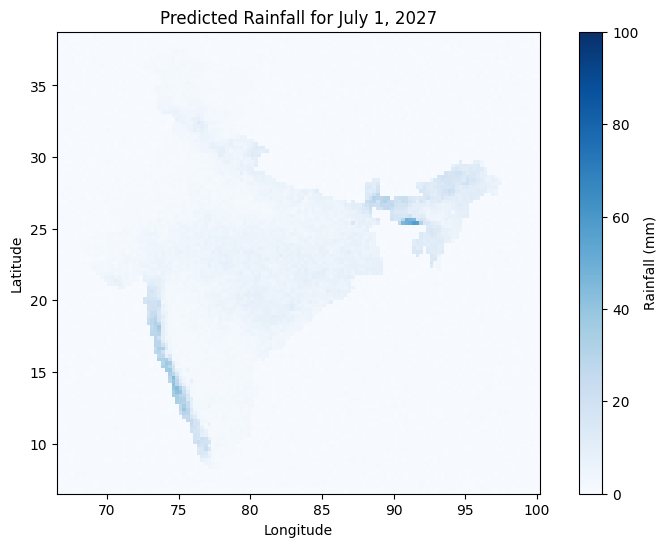

In [20]:
import calendar
# Initialize forecaster
forecaster = RainfallForecaster(model, {'min_year': 1992, 'max_year': 2024})

year = 2027
month_number = 7
day = 1

future_rain = forecaster.predict(year, month_number, day).reshape(original_shape[1], original_shape[2])


month = calendar.month_name[month_number]

plt.figure(figsize=(10, 6))
plt.imshow(future_rain, extent=[66.5, 100.25, 6.5, 38.75],
           cmap='Blues', vmin=0, vmax=100, origin='lower')
plt.colorbar(label='Rainfall (mm)')
plt.title(f"Predicted Rainfall for {month} {day}, {year}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()



In [21]:
model.save("high_performance_model_1.keras")

/home/nikunj/Documents/Projects/Disaster/Disaster/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


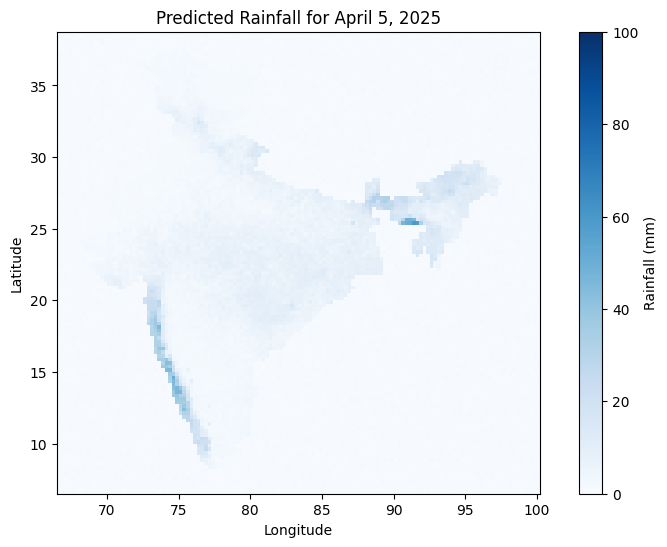

In [22]:
forecaster = RainfallForecaster(model, {'min_year': 1992, 'max_year': 2024})
model = tf.keras.models.load_model("high_performance_model.keras")
# Example prediction
future_rain = forecaster.predict(2024, 7, 5).reshape(original_shape[1], original_shape[2])

plt.figure(figsize=(10, 6))
plt.imshow(future_rain, extent=[66.5, 100.25, 6.5, 38.75],
           cmap='Blues', vmin=0, vmax=100, origin='lower')
plt.colorbar(label='Rainfall (mm)')
plt.title("Predicted Rainfall for April 5, 2025")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [24]:
class RainfallForecaster:
    def __init__(self, model, scaler_params):
        self.model = model
        self.min_year = scaler_params['min_year']
        self.max_year = scaler_params['max_year']
        
    def predict(self, state, district, year, month, day):
        """Predict rainfall for the specified state, district, and date."""
        if not (1992 <= year <= 2030):
            raise ValueError(f"Year must be between {self.min_year}-{self.max_year}")
        
        # Prepare input features for the model (based on the date)
        date = pd.Timestamp(f"{year}-{month}-{day}")
        day_angle = 2 * np.pi * date.dayofyear / 365
        
        # Define the features
        features = np.array([[
            np.sin(day_angle),
            np.cos(day_angle),
            np.sin(2 * day_angle),
            np.cos(2 * day_angle),
            month / 12,
            (year - self.min_year) / (self.max_year - self.min_year)
        ]])

        # Make the prediction
        predicted_rainfall = self.model.predict(features, verbose=0)
        predicted_rainfall = predicted_rainfall * 300.0  # Scale back to mm
        
        return predicted_rainfall[0][0]


scaler_params = {
    'min_year': 1992,
    'max_year': 2024  
}


model = tf.keras.models.load_model("high_performance_model.keras")
forecaster = RainfallForecaster(model, {'min_year': 1992, 'max_year': 2024})

# Example prediction for Shimla, Himachal Pradesh on a specific date
predicted_rainfall = forecaster.predict("Rajasthan", "Jaipur", 2020, 7, 15)
print(f"Predicted rainfall for Jaipur on 2025-06-15: {predicted_rainfall:.2f} mm")


Predicted rainfall for Jaipur on 2025-06-15: 0.66 mm
